# Predicting Heart Disease

In this project, we're implementing a machine model from a [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) of anonymized patient  of heart disease with several healthcare attributes.

In [58]:
# Import the relevant libraries:

import pandas as pd       
# ^ To read the dataset (.csv)

from sklearn.model_selection import train_test_split, GridSearchCV
# ^ To split the data into 3 parts

from sklearn.preprocessing import MinMaxScaler
# ^ To scale high interval values into [0..1] >>

from sklearn.metrics import accuracy_score
# ^ To show the accuracy of the model we're using

from sklearn.neighbors import KNeighborsClassifier
# ^ To call the ML model we're using: K-Nearest Neighbors (knn)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# ^ For data visualization

In [3]:
# Read the data:
hd_data = pd.read_csv('heart_disease_prediction.csv')

### Data Exploration:

In [9]:
# Show first 5 rows:
hd_data.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
672,60,F,NAP,120,178,1,Normal,96,N,0.0,Up,0
205,50,M,ASY,150,215,0,Normal,140,Y,0.0,Up,0
702,59,M,TA,178,270,0,LVH,145,N,4.2,Down,0
370,60,M,ASY,135,0,0,Normal,63,Y,0.5,Up,1
312,41,M,ASY,125,0,1,Normal,176,N,1.6,Up,1


In [6]:
# Print the number 
print(hd_data.dtypes)
hd_data.dtypes.value_counts()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


int64      6
object     5
float64    1
dtype: int64

There are 7 numerical and 5 categorical values. However, `FastingBS` and `HeartDisease` are also included as categorical (the values are 0 and 1 as in boolean)

## EDA: Descriptive Statistics

The numerical values have normal ranges in each columns, let's check them out.

In [10]:
# Print descriptive statistics of numerical values:
hd_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the tables above, we got:

* Seems like there are no null values (all 918 across the board)

* The patient are min(age) = 28 to max(age) = 77

* There are several data that needs a check, such as:

    * min(RestingBP) = 0; This is invalid since it means the heart doesn't beat
    * min(Cholesterol) = 0; 0 seems invalid. We need to check the normal range
    * max(Cholesterol) = 603; idem

Since there are several invalid values, we need to clean the dataset. But before that, we need to dive into the relations between the labels and target.

After exploring the domain knowledge, we get an information from [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean) that:

> A serum cholesterol consists of HDL and LDL cholesterol levels, plus 20% of your triglyceride level.

This confirms that the score of min(Cholesterol) = 0 is unlikely.

Let's dive in the data further. We'll see the missing values, and also visualize things, such as the num-ctg values: `FastingBS` and `HeartDisease` columns, and others.

In [13]:
hd_data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [17]:
# Descriptive Statistics: Categorical Data
hd_data.describe(include=['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [18]:
hd_data['FastingBS'].unique(), hd_data['HeartDisease'].unique()

(array([0, 1]), array([0, 1]))

Let's put data visualization into the plate:

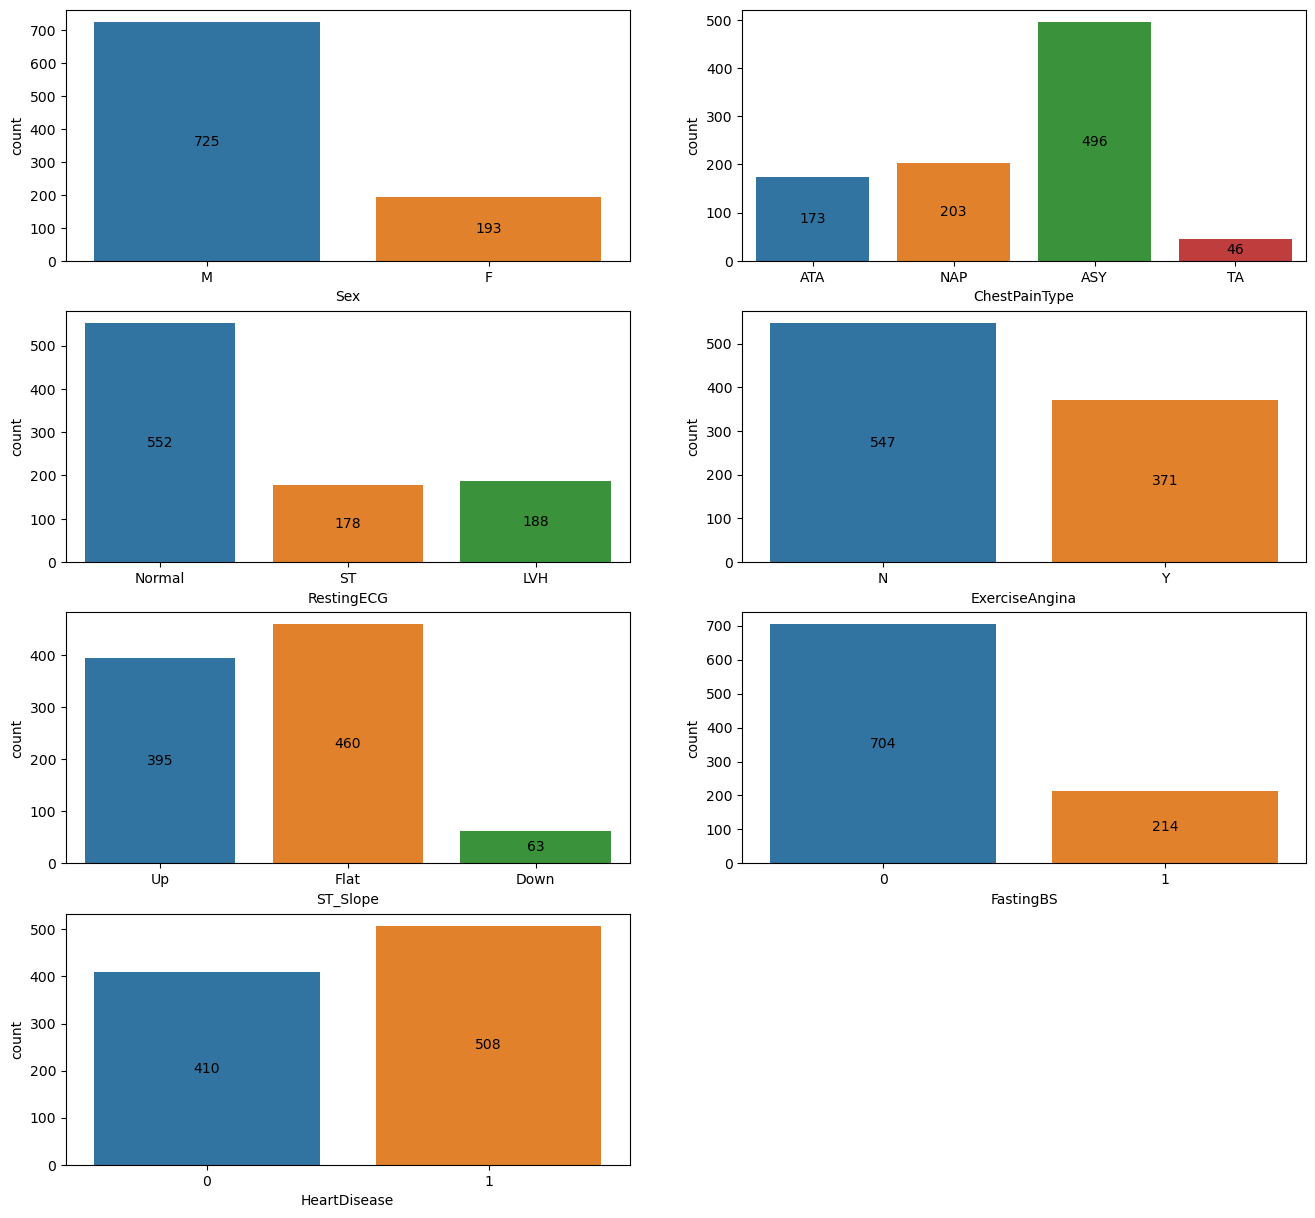

In [19]:
ctg_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina',
               'ST_Slope', 'FastingBS', 'HeartDisease']

fig = plt.figure(figsize=(16,15))

# Data-vis for each col in ctg_columns
for idx, col in enumerate(ctg_columns):
    ax = plt.subplot(4, 2, idx+1)          # Assign the graphs
    sns.countplot(x=hd_data[col], ax=ax)   # Plot each columns
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

Let's pick some insights from these graphs:

* Patients are mostly male (725 over 193). The model can induce bias due to the imbalance.
* 496 patients have `ASY` (asymptotic) type of chest pain
* 552 patients have normal `RestingECG`
* 704 patients have low fasting blood sugar `FastingBS`,
    * `FastingBS == 1` means the blood sugar reaches 120 mg/dl
    
Let's group the categorical labels with the target `HeartDisease` to get better insights for applying the ML model.

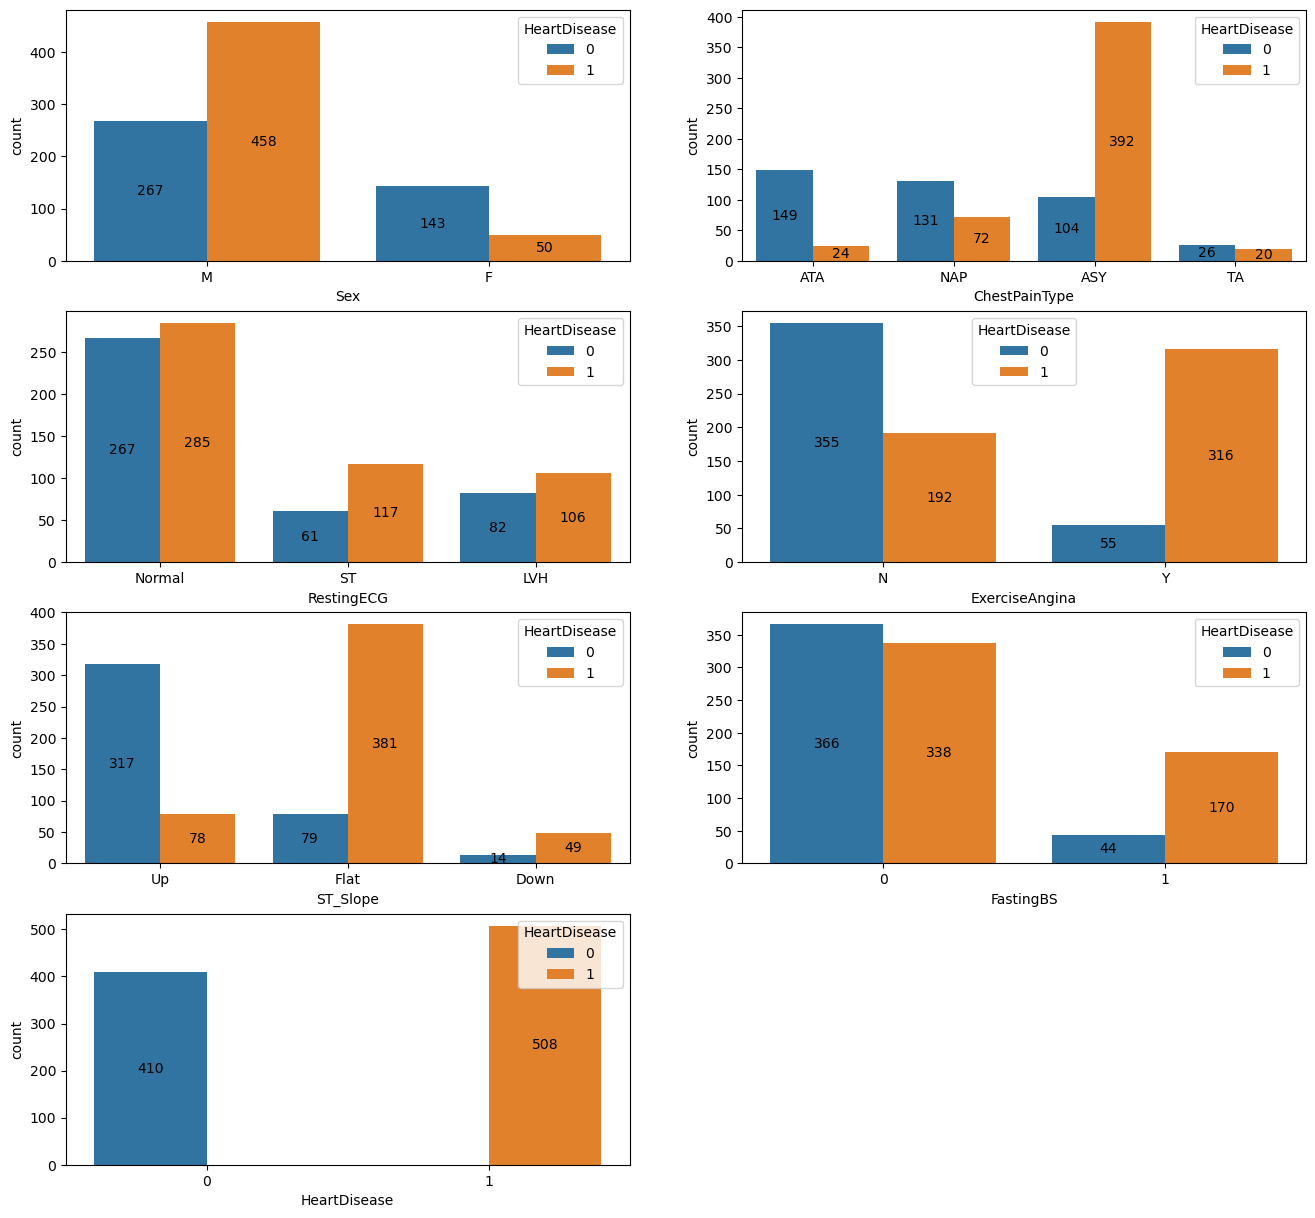

In [21]:
# Data visualization, grouped by `HeartDisease`:

fig = plt.figure(figsize=(16,15))

for idx,col in enumerate(ctg_columns):
    ax = plt.subplot(4, 2, idx+1)
    # Group the graphs by column `HeartDisease`:
    sns.countplot(x = hd_data[col], hue = hd_data['HeartDisease'], ax=ax)
    # Add data labels to each bar:
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

From the insights we can get:
    
* Most patients who's diagnosed with `HeartDisease` are male. Only 50 patients with `HeartDisease` are female, compared to male with 458 patients.
* 392 patients with `HeartDisease` have `ASY` (asymptotic) `ChestPainType`. Chest pain could be relevant to our model, but in this dataset it contradicts--`ASY` implies that they have no chest pain as a symptom.
* 170 patients with `HeartDisease` have `FastingBS`; blood sugar > 120 mg/dL in relation to those who's not diagnosed as such.
* 381 patients with `HeartDisease` with flat `ST_Slope`. 
    * **Domain knowledge:** ST slope means that there are no hyperpolarization: K+ pumps decreases peak potential over the resting potential making it negative. Less K+ pumps can lead to hyperkalemia and then a type of `HeartDisease` called STEMI (ST-elevation Myocardial Infarction)

## Data Cleaning

Let's check on the invalid data: `RestingBP` and `Cholesterol`.

In [31]:
hd_data[hd_data['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [32]:
hd_data[hd_data['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


As we can see, there's only 1 values with `RestingBP == 0`, but there are 172 rows of `Cholesterol == 0`. We can remove the `RestingBP`, but for the case of `Cholesterol`, 172 over 918 rows is a high number--pretty risky to remove them all. 

We can change the value with the two median values of `Cholesterol`; we'll mask it for values on patients (1) with and (2) without `HeartDisease`. Let's clean them up!

In [36]:
hd_data_clean = hd_data.copy()
hd_data_clean = hd_data_clean[hd_data_clean['RestingBP'] != 0]

hd_mask = hd_data_clean['HeartDisease'] == 0

chol_without_hd = hd_data_clean.loc[hd_mask, 'Cholesterol']
chol_with_hd = hd_data_clean.loc[~hd_mask, 'Cholesterol']

# Replace the values + assign it directly to `hd_data_clean`:
hd_data_clean.loc[hd_mask, 'Cholesterol'] = (
    chol_without_hd.replace(to_replace = 0, value = chol_without_hd.median())
)

hd_data_clean.loc[~hd_mask, 'Cholesterol'] = (
    chol_with_hd.replace(to_replace = 0, value = chol_with_hd.median())
)

In [37]:
# Check the descriptive statistics:
hd_data_clean[['Cholesterol', 'RestingBP']].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


Now we have no more zero values!

## Feature Selection

Now we've cleaned the data, let's expand the categorical values with `pd.get_dummies()` for us to apply the ML model. The categorical columns include `[Age, Sex, ChestPainType, Cholesterol, FastingBS]`. 

We'll also find correlations with the dataset expansion for us to narrow down the relevant features using a `sns.heatmap()`

In [42]:
# Expand the categorical values into several more columns
hd_data_clean = pd.get_dummies(hd_data_clean, drop_first=True)
hd_data_clean.sample(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
323,62,115,217,1,128,2.5,1,1,0,0,0,1,0,1,0,0
805,54,140,239,0,160,1.2,0,1,0,0,0,1,0,0,0,1
569,55,158,217,0,110,2.5,1,1,0,0,0,1,0,1,1,0
419,55,142,228,0,149,2.5,1,1,0,0,0,0,1,1,0,1
341,64,110,217,1,114,1.3,1,1,0,0,0,1,0,1,0,0


<AxesSubplot:>

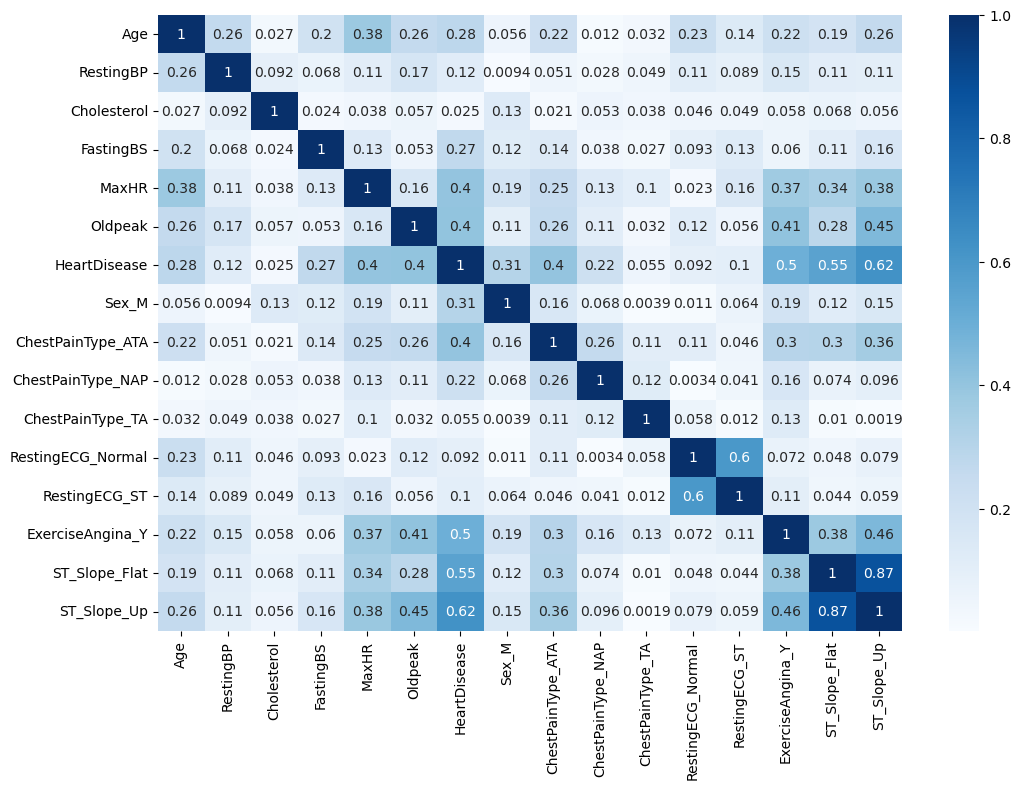

In [43]:
# Find correlations with sns.heatmap()
correlations = abs(hd_data_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap='Blues') 

<AxesSubplot:>

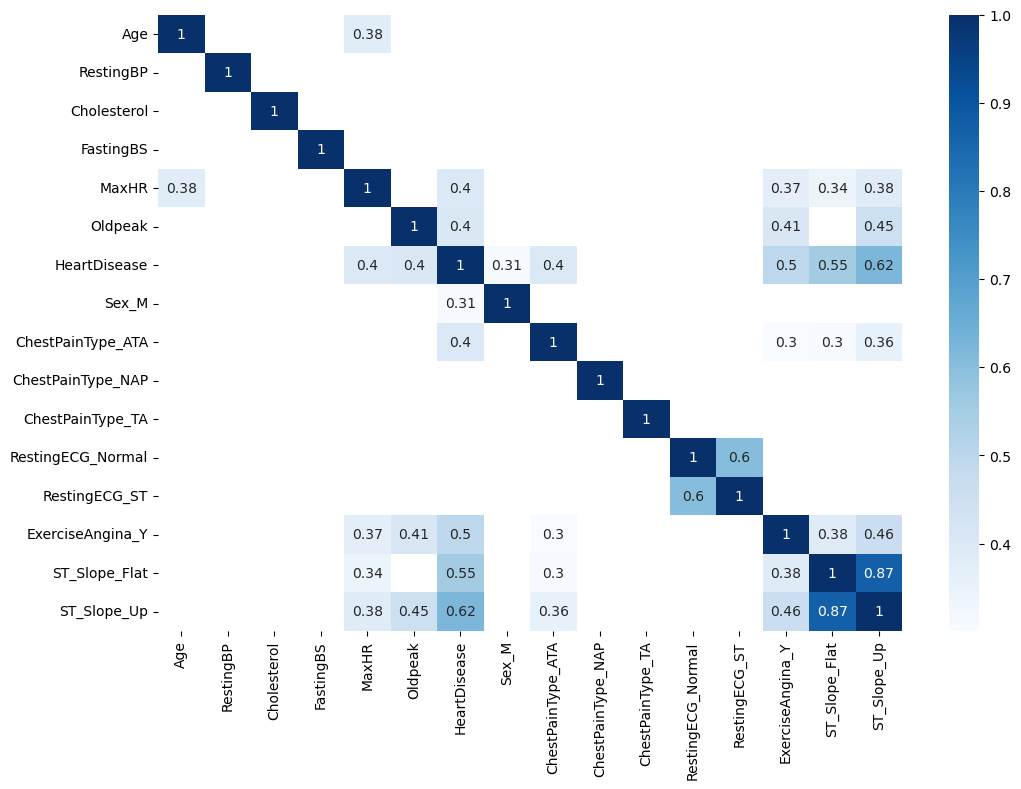

In [44]:
# Show correlations > 0.3
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap='Blues') 

From our correlation heat map, we can identify the following features related to `HeartDisease` (look at heatmap, line 7):

* `MaxHR` ✅
* `Oldpeak` ✅
* `ChestPainType_ATA` ✅
* `ExerciseAngina_Y`✅
* `ST_Slope_Flat`✅
* `ST_Slope_Up`✅
* `Sex_M`
    * Even though the correlations are relatively low, we've observed that most patients with `HeartDisease` are male, so we'll take it into account.
    
Also, surprisingly `Cholesterol` is not strongly correlated to `HeartDisease`. We can consider ignoring the feature for now.

## Building a Classifier with One Feature

Now we've find the relevant features on `HeartDisease`, we can proceed to make a ML model. We'll be using k-Nearest Neighbors (k-NN) for this project.

In [54]:
X = hd_data_clean.drop(['HeartDisease'], axis=1)
y = hd_data_clean['HeartDisease']

features = [
    'Oldpeak',
    'Sex_M',
    'ExerciseAngina_Y',
    'ST_Slope_Flat',
    'ST_Slope_Up'
]

X_train, X_val, y_train, y_val = train_test_split(
                                    X, y, test_size=0.15, random_state = 417)

We'll start by creating a model using the relevant features and evaluate their performance through accuracy metric.

In [56]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f'''
The k-NN classifier trained on `{feature}` and \
with k = 3 has an accuracy of {accuracy*100:.2f}%''')


The k-NN classifier trained on `Oldpeak` and with k = 3 has an accuracy of 76.81%

The k-NN classifier trained on `Sex_M` and with k = 3 has an accuracy of 44.93%

The k-NN classifier trained on `ExerciseAngina_Y` and with k = 3 has an accuracy of 73.19%

The k-NN classifier trained on `ST_Slope_Flat` and with k = 3 has an accuracy of 81.88%

The k-NN classifier trained on `ST_Slope_Up` and with k = 3 has an accuracy of 84.06%


After training k-NN on each features, we get a number of accuracy. Ordered from highest to lowest, we have: 
* `ST_Slope_Up` by 84.06%, followed by 
* `ST_Slope_Flat` by 81.88%, 
* `Oldpeak` by 76.81%, 
* `ExerciseAngina_Y` by 73.1%, 
* and lastly `Sex_M` by 44.93%.

## Building a Classifier with Multiple Features

Now we'll try to train k-NN with multiple features together to see the compound accuracy. Since the ranges are different, we need to normalize them first to an interval of [0..1]

In [57]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled   = scaler.transform(X_val[features])

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 86.23%


We're getting an accuracy og 86.23%--a bit more than previous ones, it's a good start. We can optimize this more by using hyperparameter tuning.

## Hyperparameter Tuning

Now we've trained the model with all relevant features, we can tune the model up to get higher accuracy. We'll use `GridSearchCV` library tu tune the parameters. Let's prepare the data first.  

In [60]:
X = hd_data_clean.drop(['HeartDisease'], axis=1)
y = hd_data_clean['HeartDisease']

features = [
    'Oldpeak',
    'Sex_M',
    'ExerciseAngina_Y',
    'ST_Slope_Flat',
    'ST_Slope_Up'
]

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.15, random_state = 417)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

To optimize the accuracy, we'll be using grid parameter that consists of:
* Number of nearest neighbors `k` in range of `(1,20)`, and
* two distance metrics: `['minkowski', 'manhattan']`

In [61]:
# Setting up a grid parameter:
grid_params = {'n_neighbors': range(1,20),
               'metric': ['minkowski', 'manhattan']
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy') 
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [62]:
# Print the best accuracy and best parameter:
knn_grid.best_score_ * 100, knn_grid.best_params_

(83.56327543424318, {'metric': 'minkowski', 'n_neighbors': 19})

After applying `GridSearchCV`, we get a high accuracy of 83.56% with parameters of:
* number of neighbors `k` or `n_neighbors` of 19, and
* distance metrics of [`minkowski`](https://en.wikipedia.org/wiki/Minkowski_distance)

Even though it's a bit smaller than what we previously get, `GridSearchCV` employs a cross-validation approach, this implies a better estimate of how the model performs rather than our prior attempts.

## Model Evaluation on Test Set

Now we've got a good estimation of high accuracy, we can apply it to our test set `X_test`. Given the multiple features and various ranges, we need to normalize it first.

In [63]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}%")

 Model Accuracy on test set: 86.23%


The accuracy is high! We're doing great! But you may be wondering: 

> *"Why does the model accuracy on test relatively higher? It should've been the same."*

Remember the `Sex_M` data distribution on patients with `HeartDisease`? The dataset has a majority of male from the graphs we've created beforehand. Let's check the sets distribution:

In [65]:
print("Distribution of patients `Sex` in the whole set")
print(X.Sex_M.value_counts())

print("Distribution of patients `Sex` in the training set")
print(X_train.Sex_M.value_counts())

print("Distribution of patients `Sex` in test set")
print(X_test.Sex_M.value_counts())

Distribution of patients `Sex` in the whole set
1    724
0    193
Name: Sex_M, dtype: int64
Distribution of patients `Sex` in the training set
1    615
0    164
Name: Sex_M, dtype: int64
Distribution of patients `Sex` in test set
1    109
0     29
Name: Sex_M, dtype: int64


From the data above we can see that the dataset has more male patients on all set. This confirms the bias the model may induce. But of course there could be other factors in hand.

## Conclusions

This project aims to make a machine learning model of k-Nearest Neighbors (k-NN) with the help of GridSearchCV to define the best parameters. The training results on a high accuracy of 86.23%. 

There are quite a few things we can utilize to get a better results:
* Expand the grid search parameters with more optimal hyperparameters,
* Explore other models than k-NN that might perform better, or
* Collect more data for better representation.